# Library

In [1]:
from google.colab import drive
import os
drive.mount('/content/drive')
!pip install tensorboardX
!pip install piq
os.chdir('/content/drive/MyDrive/GT-RAIN')


Mounted at /content/drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 KB 11.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.5/139.5 KB 17.2 MB/s eta 0:00:00


In [2]:
import sys
import os

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms.functional as TF
from torch.autograd import Variable
import functools
from torch.nn import init
import torchvision

from PIL import Image, ImageChops, ImageOps, ImageEnhance
import random
from natsort import natsorted
from glob import glob

from tqdm.notebook import tqdm
from pathlib import Path
import time
import numpy as np
from tensorboardX import SummaryWriter
%load_ext tensorboard
from skimage import img_as_ubyte
import cv2
%matplotlib inline
import matplotlib.pyplot as plt
from math import exp
from piq import MultiScaleSSIMLoss
import math
import copy

# Helper


In [3]:
# Plot image
def show_img(img, title=None, figsize=(15, 15)):
  #img = (img+1)/2
    plt.figure(figsize=figsize)
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.show()

# Data Augmentation

In [4]:
# ROTATION DATA AUGMENTATION CODE
# Code modified from https://stackoverflow.com/questions/16702966/rotate-image-and-crop-out-black-borders

def get_translation_matrix_2d(dx, dy):
    """
    Returns a numpy affine transformation matrix for a 2D translation of
    (dx, dy)
    """
    return np.matrix([[1, 0, dx], [0, 1, dy], [0, 0, 1]])

def rotate_image(image, angle):
    """
    Rotates the given image about it's centre
    """

    image_size = (image.shape[1], image.shape[0])
    image_center = tuple(np.array(image_size) / 2)

    rot_mat = np.vstack([cv2.getRotationMatrix2D(image_center, angle, 1.0), [0, 0, 1]])
    trans_mat = np.identity(3)

    w2 = image_size[0] * 0.5
    h2 = image_size[1] * 0.5

    rot_mat_notranslate = np.matrix(rot_mat[0:2, 0:2])

    tl = (np.array([-w2, h2]) * rot_mat_notranslate).A[0]
    tr = (np.array([w2, h2]) * rot_mat_notranslate).A[0]
    bl = (np.array([-w2, -h2]) * rot_mat_notranslate).A[0]
    br = (np.array([w2, -h2]) * rot_mat_notranslate).A[0]

    x_coords = [pt[0] for pt in [tl, tr, bl, br]]
    x_pos = [x for x in x_coords if x > 0]
    x_neg = [x for x in x_coords if x < 0]

    y_coords = [pt[1] for pt in [tl, tr, bl, br]]
    y_pos = [y for y in y_coords if y > 0]
    y_neg = [y for y in y_coords if y < 0]

    right_bound = max(x_pos)
    left_bound = min(x_neg)
    top_bound = max(y_pos)
    bot_bound = min(y_neg)

    new_w = int(abs(right_bound - left_bound))
    new_h = int(abs(top_bound - bot_bound))
    new_image_size = (new_w, new_h)

    new_midx = new_w * 0.5
    new_midy = new_h * 0.5

    dx = int(new_midx - w2)
    dy = int(new_midy - h2)

    trans_mat = get_translation_matrix_2d(dx, dy)
    affine_mat = (np.matrix(trans_mat) * np.matrix(rot_mat))[0:2, :]
    result = cv2.warpAffine(image, affine_mat, new_image_size, flags=cv2.INTER_LINEAR)

    return result

def rotated_rect_with_max_area(w, h, angle):
    """
    Given a rectangle of size wxh that has been rotated by 'angle' (in
    radians), computes the width and height of the largest possible
    axis-aligned rectangle (maximal area) within the rotated rectangle.
    """
    if w <= 0 or h <= 0:
        return 0,0

    width_is_longer = w >= h
    side_long, side_short = (w,h) if width_is_longer else (h,w)

    # since the solutions for angle, -angle and 180-angle are all the same,
    # if suffices to look at the first quadrant and the absolute values of sin,cos:
    sin_a, cos_a = abs(math.sin(angle)), abs(math.cos(angle))
    if side_short <= 2.*sin_a*cos_a*side_long or abs(sin_a-cos_a) < 1e-10:
        # half constrained case: two crop corners touch the longer side,
        # the other two corners are on the mid-line parallel to the longer line
        x = 0.5 * side_short
        wr,hr = (x/sin_a,x/cos_a) if width_is_longer else (x/cos_a,x/sin_a)
    else:
        # fully constrained case: crop touches all 4 sides
        cos_2a = cos_a*cos_a - sin_a*sin_a
        wr,hr = (w*cos_a - h*sin_a)/cos_2a, (h*cos_a - w*sin_a)/cos_2a

    return int(wr), int(hr)

def gen_rotate_image(img, angle):
    dim = img.shape
    h = dim[0]
    w = dim[1]

    img = rotate_image(img, angle)
    dim_bb = img.shape
    h_bb = dim_bb[0]
    w_bb = dim_bb[1]

    w_r, h_r = rotated_rect_with_max_area(w, h, math.radians(angle))

    w_0 = (w_bb-w_r) // 2
    h_0 = (h_bb-h_r) // 2
    img = img[h_0:h_0 + h_r, w_0:w_0 + w_r, :]

    return img

In [5]:
# CODE FOR RAIN MASK AUGMENTATIONS
# code modified from https://github.com/tsingqguo/efficientderain

def int_parameter(level, maxval):
    """Helper function to scale `val` between 0 and maxval .

    Args:
    level: Level of the operation that will be between [0, `PARAMETER_MAX`].
    maxval: Maximum value that the operation can have. This will be scaled to
      level/PARAMETER_MAX.

    Returns:
    An int that results from scaling `maxval` according to `level`.
    """
    return int(level * maxval / 10)


def float_parameter(level, maxval):
    """Helper function to scale `val` between 0 and maxval.

    Args:
    level: Level of the operation that will be between [0, `PARAMETER_MAX`].
    maxval: Maximum value that the operation can have. This will be scaled to
      level/PARAMETER_MAX.

    Returns:
    A float that results from scaling `maxval` according to `level`.
    """
    return float(level) * maxval / 10.


def sample_level(n):
    return np.random.uniform(low=0.1, high=n)


def autocontrast(pil_img, _):
    return ImageOps.autocontrast(pil_img)


def equalize(pil_img, _):
    return ImageOps.equalize(pil_img)


def posterize(pil_img, level):
    level = int_parameter(sample_level(level), 4)
    return ImageOps.posterize(pil_img, 4 - level)


def rotate(pil_img, level):
    degrees = int_parameter(sample_level(level), 30)
    if np.random.uniform() > 0.5:
        degrees = -degrees
    return pil_img.rotate(degrees, resample=Image.BILINEAR)


def solarize(pil_img, level):
    level = int_parameter(sample_level(level), 256)
    return ImageOps.solarize(pil_img, 256 - level)


def shear_x(pil_img, level):
    level = float_parameter(sample_level(level), 0.3)
    if np.random.uniform() > 0.5:
        level = -level
    return pil_img.transform(
          (pil_img.width, pil_img.height),
          Image.AFFINE, (1, level, 0, 0, 1, 0),
          resample=Image.BILINEAR)


def shear_y(pil_img, level):
    level = float_parameter(sample_level(level), 0.3)
    if np.random.uniform() > 0.5:
        level = -level
    return pil_img.transform(
          (pil_img.width, pil_img.height),
          Image.AFFINE, (1, 0, 0, level, 1, 0),
          resample=Image.BILINEAR)


def roll_x(pil_img, level):
  
    delta = int_parameter(sample_level(level), pil_img.width / 3)
    if np.random.random() > 0.5:
        delta = -delta
    xsize, ysize = pil_img.size
    delta = delta % xsize
    if delta == 0: return pil_img
    part1 = pil_img.crop((0, 0, delta, ysize))
    part2 = pil_img.crop((delta, 0, xsize, ysize))
    pil_img.paste(part1, (xsize-delta, 0, xsize, ysize))
    pil_img.paste(part2, (0, 0, xsize-delta, ysize))

    return pil_img

def roll_y(pil_img, level):
    delta = int_parameter(sample_level(level), pil_img.width / 3)
    if np.random.random() > 0.5:
        delta = -delta
    xsize, ysize = pil_img.size
    delta = delta % ysize
    if delta == 0: return pil_img
    part1 = pil_img.crop((0, 0, xsize, delta))
    part2 = pil_img.crop((0, delta, xsize, ysize))
    pil_img.paste(part1, (0, ysize-delta, xsize, ysize))
    pil_img.paste(part2, (0, 0, xsize, ysize-delta))

    return pil_img

# operation that overlaps with ImageNet-C's test set
def color(pil_img, level):
    level = float_parameter(sample_level(level), 1.8) + 0.1
    return ImageEnhance.Color(pil_img).enhance(level)


# operation that overlaps with ImageNet-C's test set
def contrast(pil_img, level):
    level = float_parameter(sample_level(level), 1.8) + 0.1
    return ImageEnhance.Contrast(pil_img).enhance(level)


# operation that overlaps with ImageNet-C's test set
def brightness(pil_img, level):
    level = float_parameter(sample_level(level), 1.8) + 0.1
    return ImageEnhance.Brightness(pil_img).enhance(level)


# operation that overlaps with ImageNet-C's test set
def sharpness(pil_img, level):
    level = float_parameter(sample_level(level), 1.8) + 0.1
    return ImageEnhance.Sharpness(pil_img).enhance(level)

def zoom_x(pil_img, level):
    # zoom from .02 to 2.5
    rate = level
    zoom_img = pil_img.transform(
      (pil_img.width, pil_img.height),
      Image.AFFINE, (rate, 0, 0, 0, 1, 0),
      resample=Image.BILINEAR)
    # need to do reflect padding
    if rate > 1.0:
        orig_x, orig_y = pil_img.size
        new_x = int(orig_x/rate)
        zoom_img = np.array(zoom_img)
        zoom_img = np.pad(zoom_img[:, :new_x, :], ((0, 0), (0, orig_x-new_x), (0,0)), 'wrap')
    return zoom_img

def zoom_y(pil_img, level):
  # zoom from .02 to 2.5
    rate = level
    zoom_img = pil_img.transform(
      (pil_img.width, pil_img.height),
      Image.AFFINE, (1, 0, 0, 0, rate, 0),
      resample=Image.BILINEAR)
    # need to do reflect padding
    if rate > 1.0:
        orig_x, orig_y = pil_img.size
        new_y = int(orig_y/rate)
        zoom_img = np.array(zoom_img)
        zoom_img = np.pad(zoom_img[:new_y, :, :], ((0, orig_y-new_y), (0, 0), (0,0)), 'wrap')
    return zoom_img
    

augmentations = [
    rotate, shear_x, shear_y,
    zoom_x, zoom_y, roll_x, roll_y
]

augmentations_all = [
    autocontrast, equalize, posterize, rotate, solarize, shear_x, shear_y,
    roll_x, roll_y, color, contrast, brightness, sharpness
]

In [6]:
# RAIN MASK AUGMENTATION CODE
# code modified from https://github.com/tsingqguo/efficientderain

class RandomCrop(object):
    def __init__(self, image_size, crop_size):
        self.ch, self.cw = crop_size
        ih, iw = image_size

        self.h1 = random.randint(0, ih - self.ch)
        self.w1 = random.randint(0, iw - self.cw)

        self.h2 = self.h1 + self.ch
        self.w2 = self.w1 + self.cw

    def __call__(self, img):
        if len(img.shape) == 3:
            return img[self.h1: self.h2, self.w1: self.w2, :]
        else:
            return img[self.h1: self.h2, self.w1: self.w2]

def getRainLayer2(rand_id1, rand_id2, rain_mask_dir):
    path_img_rainlayer_src = os.path.join(rain_mask_dir, f'{rand_id1}-{rand_id2}.png')
    rainlayer_rand = cv2.imread(path_img_rainlayer_src).astype(np.float32) / 255.0
    rainlayer_rand = cv2.cvtColor(rainlayer_rand, cv2.COLOR_BGR2RGB)
    return rainlayer_rand

def getRandRainLayer2(rain_mask_dir):
    rand_id1 = random.randint(1, 165)
    rand_id2 = random.randint(4, 8)
    rainlayer_rand = getRainLayer2(rand_id1, rand_id2, rain_mask_dir)
    return rainlayer_rand
  
def rain_aug(img_rainy, img_gt, rain_mask_dir, zoom_min = 0.06, zoom_max = 1.8):
    img_rainy = (img_rainy.astype(np.float32)) / 255.0
    img_gt = (img_gt.astype(np.float32)) / 255.0
    img_rainy_ret = img_rainy
    img_gt_ret = img_gt

    rainlayer_rand2 = getRandRainLayer2(rain_mask_dir)
    rainlayer_aug2 = augment_and_mix(rainlayer_rand2, severity = 3, width = 3, depth = -1, zoom_min = zoom_min, zoom_max = zoom_max) * 1

    height = min(img_rainy.shape[0], rainlayer_aug2.shape[0])
    width = min(img_rainy.shape[1], rainlayer_aug2.shape[1])

    cropper = RandomCrop(rainlayer_aug2.shape[:2], (height, width))
    rainlayer_aug2_crop = cropper(rainlayer_aug2)
    cropper = RandomCrop(img_rainy.shape[:2], (height, width))
    img_rainy_ret = cropper(img_rainy_ret)
    img_gt_ret = cropper(img_gt_ret)
    img_rainy_ret = img_rainy_ret + rainlayer_aug2_crop - img_rainy_ret*rainlayer_aug2_crop
    img_rainy_ret = np.clip(img_rainy_ret, 0.0, 1.0)
    img_rainy_ret = (img_rainy_ret * 255).astype(np.uint8)
    img_gt_ret = (img_gt_ret * 255).astype(np.uint8)

    return img_rainy_ret, img_gt_ret

def augment_and_mix(image, severity=3, width=3, depth=-1, alpha=1., zoom_min=0.06, zoom_max=1.8):
    """Perform AugMix augmentations and compute mixture.
    Args:
    image: Raw input image as float32 np.ndarray of shape (h, w, c)
    severity: Severity of underlying augmentation operators (between 1 to 10).
    width: Width of augmentation chain
    depth: Depth of augmentation chain. -1 enables stochastic depth uniformly
      from [1, 3]
    alpha: Probability coefficient for Beta and Dirichlet distributions.
    Returns:
    mixed: Augmented and mixed image.
    """
    ws = np.float32(
      np.random.dirichlet([alpha] * width))
    m = np.float32(np.random.beta(alpha, alpha))

    mix = np.zeros_like(image)
    for i in range(width):
        image_aug = image.copy()
        depth = depth if depth > 0 else np.random.randint(2, 4)
        for _ in range(depth):
            op = np.random.choice(augmentations)
            if (op == zoom_x or op == zoom_y):
                rate = np.random.uniform(low=zoom_min, high=zoom_max)
                image_aug = apply_op(image_aug, op, rate)
            else:
                image_aug = apply_op(image_aug, op, severity)
        # Preprocessing commutes since all coefficients are convex
        mix += ws[i] * image_aug
    
    max_ws = max(ws)
    rate = 1.0 / max_ws  

    mixed = max((1 - m), 0.7) * image + max(m, rate*0.5) * mix
    return mixed

def apply_op(image, op, severity):
    image = np.clip(image * 255., 0, 255).astype(np.uint8)
    pil_img = Image.fromarray(image)  # Convert to PIL.Image
    pil_img = op(pil_img, severity)
    return np.asarray(pil_img) / 255.

# Dataloader

In [7]:
# DataLoaders for Training and Validation set

class GTRainDataset(Dataset):
    """
    The dataset class for weather net training and validation.

    Parameters:
        train_dir_list (list) -- list of dirs for the dataset.
        val_dir_list (list) -- list of dirs for the dataset.
        rain_mask_dir (string) -- location of rain masks for data augmentation.
        img_size (int) -- size of the images after cropping.
        is_train (bool) -- True for training set.
        val_list (list) -- list of validation scenes
        sigma (int) -- variance for random angle rotation data augmentation
        zoom_min (float) -- minimum zoom for RainMix data augmentation
        zoom_max (float) -- maximum zoom for RainMix data augmentation
    """
    def __init__(self, train_dir_list, val_dir_list, rain_mask_dir, img_size, is_train=True, sigma=13, zoom_min=0.06, zoom_max=1.8):
        super(GTRainDataset, self).__init__()

        self.rain_mask_dir = rain_mask_dir
        self.img_size = img_size
        self.is_train = is_train
        self.img_paths = []
        self.sigma = sigma
        self.zoom_min = zoom_min
        self.zoom_max = zoom_max
        self.scene_indices = []
        last_index = 0
        scene_paths = []
        if is_train:
            root_dir_list = train_dir_list
        else:
            root_dir_list = val_dir_list

        for root_dir in root_dir_list:
            scene_paths += [os.path.join(root_dir, scene) for scene in list(os.walk(root_dir))[0][1]]
    
        for scene_path in scene_paths:
            scene_img_paths = natsorted(glob(os.path.join(scene_path, '*R-*.png')))
            scene_length = len(scene_img_paths)
            self.scene_indices.append(list(range(last_index, last_index + scene_length)))
            last_index += scene_length
            self.img_paths += scene_img_paths
    
        # number of images in full dataset
        self.data_len = len(self.img_paths)
  
    def __len__(self):
        return self.data_len

    def get_scene_indices(self):
        return self.scene_indices
  
    def __getitem__(self, index):
        ts = self.img_size

        inp_path = self.img_paths[index]
        tar_path = self.img_paths[index][:-9] + 'C-000.png'
        if('Gurutto_1-2' in inp_path):
            tar_path = self.img_paths[index][:-9] + 'C' + self.img_paths[index][-8:]
        inp_img = Image.open(inp_path)
        tar_img = Image.open(tar_path)

        # To numpy
        inp_img = np.array(inp_img)
        tar_img = np.array(tar_img)

        if self.is_train:
            if random.randint(1, 10) > 4:
                inp_img, tar_img = rain_aug(inp_img, tar_img, self.rain_mask_dir, zoom_min=self.zoom_min, zoom_max=self.zoom_max)

        # Random rotation
        if self.is_train:
            angle = np.random.normal(0, self.sigma)
            inp_img_rot = gen_rotate_image(inp_img, angle)
            if (inp_img_rot.shape[0] >= 256 and inp_img_rot.shape[1] >= 256):
                inp_img = inp_img_rot
                tar_img = gen_rotate_image(tar_img, angle)

        # reflect pad and random cropping to ensure the right image size for training
        h,w = inp_img.shape[:2]

        # To tensor
        inp_img = TF.to_tensor(inp_img)
        tar_img = TF.to_tensor(tar_img)

        # reflect padding
        padw = ts-w if w<ts else 0
        padh = ts-h if h<ts else 0
        if padw!=0 or padh!=0:
            inp_img = TF.pad(inp_img, (0, 0, padw, padh), padding_mode='reflect')
            tar_img = TF.pad(tar_img, (0, 0, padw, padh), padding_mode='reflect')
    
        if self.is_train:
            # random cropping
            hh, ww, = inp_img.shape[1], inp_img.shape[2]
            rr = random.randint(0, hh-ts)
            cc = random.randint(0, ww-ts)
            inp_img = inp_img[:, rr:rr+ts, cc:cc+ts]
            tar_img = tar_img[:, rr:rr+ts, cc:cc+ts]
        else:
            # center cropping
            inp_img = TF.center_crop(inp_img, (ts, ts))
            tar_img = TF.center_crop(tar_img, (ts, ts))

        # Data augmentations: flip x, flip y
        if self.is_train:
            aug = random.randint(0, 2)
        else:
            aug = 0

        if aug==1:
            inp_img = inp_img.flip(1)
            tar_img = tar_img.flip(1)
        elif aug==2:
            inp_img = inp_img.flip(2)
            tar_img = tar_img.flip(2)

        # Get image name
        file_name = inp_path.split('/')[-1]

        # Dict for return
        # If using tanh as the last layer, the range should be [-1, 1]
        sample_dict = {
            'input_img': inp_img * 2 - 1,
            'target_img': tar_img * 2 - 1,
            'file_name': file_name
        }

        return sample_dict

In [8]:
# Samplper for the images

class CustomBatchSampler():
    def __init__(self, scene_indices, batch_size=16):
        self.scene_indices = scene_indices
        self.batch_size = batch_size
        self.num_batches = int(scene_indices[-1][-1]/batch_size)

    def __len__(self):
        return self.num_batches

    def __iter__(self):
        scene_indices = copy.deepcopy(self.scene_indices)
        for scene_list in scene_indices:
            random.shuffle(scene_list)
        out_indices = []
        done = False
        while not done:
            out_batch_indices = []
            if (len(scene_indices) < self.batch_size):
                self.num_batches = len(out_indices)
                return iter(out_indices)
            chosen_scenes = np.random.choice(len(scene_indices), self.batch_size, replace = False)
            empty_indices = []
            for i in chosen_scenes:
                scene_list = scene_indices[i]
                out_batch_indices.append(scene_list.pop())
                if (len(scene_list) == 0):
                    empty_indices.append(i)
            empty_indices.sort(reverse=True)
            for i in empty_indices:
                scene_indices.pop(i)
            out_indices.append(out_batch_indices)
        self.num_batches = len(out_indices)
        return iter(out_indices)

# Loss

In [9]:
class ShiftMSSSIM(torch.nn.Module):
    """Shifted SSIM Loss """
    def __init__(self):
        super(ShiftMSSSIM, self).__init__()
        self.ssim = MultiScaleSSIMLoss(data_range=1.)

    def forward(self, est, gt):
        # shift images back into range (0, 1)
        est = est * 0.5 + 0.5
        gt = gt *0.5 + 0.5
        return self.ssim(est, gt)

In [10]:
# Rain Robust Loss
# Code modified from: https://github.com/sthalles/SimCLR/blob/master/simclr.py

class RainRobustLoss(torch.nn.Module):
    """Rain Robust Loss"""
    def __init__(self, batch_size, n_views, device, temperature=0.07):
        super(RainRobustLoss, self).__init__()
        self.batch_size = batch_size
        self.n_views = n_views
        self.temperature = temperature
        self.device = device
        self.criterion = torch.nn.CrossEntropyLoss().to(self.device)

    def forward(self, features):
        logits, labels = self.info_nce_loss(features)
        return self.criterion(logits, labels)

    def info_nce_loss(self, features):
        labels = torch.cat([torch.arange(self.batch_size) for i in range(self.n_views)], dim=0)
        labels = (labels.unsqueeze(0) == labels.unsqueeze(1)).float()
        labels = labels.to(self.device)

        features = F.normalize(features, dim=1)

        similarity_matrix = torch.matmul(features, features.T)

        # discard the main diagonal from both: labels and similarities matrix
        mask = torch.eye(labels.shape[0], dtype=torch.bool).to(self.device)
        labels = labels[~mask].view(labels.shape[0], -1)
        similarity_matrix = similarity_matrix[~mask].view(similarity_matrix.shape[0], -1)

        # select and combine multiple positives
        positives = similarity_matrix[labels.bool()].view(labels.shape[0], -1)

        # select only the negatives the negatives
        negatives = similarity_matrix[~labels.bool()].view(similarity_matrix.shape[0], -1)

        logits = torch.cat([positives, negatives], dim=1)
        labels = torch.zeros(logits.shape[0], dtype=torch.long).to(self.device)

        logits = logits / self.temperature
        return logits, labels

# Scheduler

In [11]:
"""
Linear warmup from: 
https://github.com/ildoonet/pytorch-gradual-warmup-lr/blob/master/warmup_scheduler/scheduler.py
"""

from torch.optim.lr_scheduler import _LRScheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau

class GradualWarmupScheduler(_LRScheduler):
    """ Gradually warm-up(increasing) learning rate in optimizer.
    Proposed in 'Accurate, Large Minibatch SGD: Training ImageNet in 1 Hour'.
    Args:
      optimizer (Optimizer): Wrapped optimizer.
      multiplier: target learning rate = base lr * multiplier if multiplier > 1.0. if multiplier = 1.0, lr starts from 0 and ends up with the base_lr.
      total_epoch: target learning rate is reached at total_epoch, gradually
      after_scheduler: after target_epoch, use this scheduler(eg. ReduceLROnPlateau)
    """

    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        self.multiplier = multiplier
        if self.multiplier < 1.:
            raise ValueError('multiplier should be greater thant or equal to 1.')
        self.total_epoch = total_epoch
        self.after_scheduler = after_scheduler
        self.finished = False
        super(GradualWarmupScheduler, self).__init__(optimizer)

    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_last_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]

        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

    def step_ReduceLROnPlateau(self, metrics, epoch=None):
        if epoch is None:
            epoch = self.last_epoch + 1
        self.last_epoch = epoch if epoch != 0 else 1  # ReduceLROnPlateau is called at the end of epoch, whereas others are called at beginning
        if self.last_epoch <= self.total_epoch:
            warmup_lr = [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]
            for param_group, lr in zip(self.optimizer.param_groups, warmup_lr):
                param_group['lr'] = lr
        else:
            if epoch is None:
                self.after_scheduler.step(metrics, None)
            else:
                self.after_scheduler.step(metrics, epoch - self.total_epoch)

    def step(self, epoch=None, metrics=None):
        if type(self.after_scheduler) != ReduceLROnPlateau:
            if self.finished and self.after_scheduler:
                if epoch is None:
                    self.after_scheduler.step(None)
                else:
                    self.after_scheduler.step(epoch - self.total_epoch)
                self._last_lr = self.after_scheduler.get_last_lr()
            else:
                return super(GradualWarmupScheduler, self).step(epoch)
        else:
            self.step_ReduceLROnPlateau(metrics, epoch)

# Model

In [12]:
# Main network blocks
# Code modified from: https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix

# Basic Blocks
class Identity(nn.Module):
    def forward(self, x):
        return x

def get_norm_layer(norm_type='instance'):
    """Return a normalization layer
    Parameters:
      norm_type (str) -- the name of the normalization layer: batch | instance | none
    For BatchNorm, we use learnable affine parameters and track running statistics (mean/stddev).
    For InstanceNorm, we do not use learnable affine parameters. We do not track running statistics.
    """
    if norm_type == 'batch':
        norm_layer = functools.partial(nn.BatchNorm2d, affine=True, track_running_stats=True)
    elif norm_type == 'instance':
        norm_layer = functools.partial(nn.InstanceNorm2d, affine=False, track_running_stats=False)
    elif norm_type == 'none':
        def norm_layer(x): return Identity()
    else:
        raise NotImplementedError('normalization layer [%s] is not found' % norm_type)
    return norm_layer

class Conv2d(torch.nn.Module):
    '''
    2D convolution class
    Args:
    in_channels : int
      number of input channels
    out_channels : int
      number of output channels
    kernel_size : int
      size of kernel
    stride : int
      stride of convolution
    activation_func : func
      activation function after convolution
    norm_layer : functools.partial
      normalization layer
    use_bias : bool
      if set, then use bias
    padding_type : str
      the name of padding layer: reflect | replicate | zero
    '''

    def __init__(
        self,
        in_channels,
        out_channels,
        kernel_size=3,
        stride=1,
        activation_func=torch.nn.LeakyReLU(negative_slope=0.10, inplace=True),
        norm_layer=nn.BatchNorm2d,
        use_bias=False,
        padding_type='reflect'):
    
        super(Conv2d, self).__init__()
    
        self.activation_func = activation_func
        conv_block = []
        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(kernel_size // 2)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(kernel_size // 2)]
        elif padding_type == 'zero':
            p = kernel_size // 2
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)

        conv_block += [
            nn.Conv2d(
              in_channels, 
              out_channels, 
              stride=stride,
              kernel_size=kernel_size, 
              padding=p, 
              bias=use_bias), 
            norm_layer(out_channels)]

        self.conv = nn.Sequential(*conv_block)

    def forward(self, x):
        conv = self.conv(x)

        if self.activation_func is not None:
            return self.activation_func(conv)
        else:
            return conv

class DeformableConv2d(nn.Module):
    '''
    2D deformable convolution class
    Args:
    in_channels : int
      number of input channels
    out_channels : int
      number of output channels
    kernel_size : int
      size of kernel
    stride : int
      stride of convolution
    padding : int
      padding
    use_bias : bool
      if set, then use bias
    '''
    def __init__(
        self,
        in_channels,
        out_channels,
        kernel_size=3,
        stride=1,
        padding=1,
        bias=False):
    
        super(DeformableConv2d, self).__init__()
      
        self.stride = stride if type(stride) == tuple else (stride, stride)
        self.padding = padding
    
        self.offset_conv = nn.Conv2d(
            in_channels, 
            2 * kernel_size * kernel_size,
            kernel_size=kernel_size, 
            stride=stride,
            padding=self.padding, 
            bias=True)

        nn.init.constant_(self.offset_conv.weight, 0.)
        nn.init.constant_(self.offset_conv.bias, 0.)
    
        self.modulator_conv = nn.Conv2d(
            in_channels, 
            1 * kernel_size * kernel_size,
            kernel_size=kernel_size, 
            stride=stride,
            padding=self.padding, 
            bias=True)

        nn.init.constant_(self.modulator_conv.weight, 0.)
        nn.init.constant_(self.modulator_conv.bias, 0.)
    
        self.regular_conv = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=self.padding,
            bias=bias)

    def forward(self, x):
        offset = self.offset_conv(x)
        modulator = 2. * torch.sigmoid(self.modulator_conv(x))
    
        x = torchvision.ops.deform_conv2d(
            input=x, 
            offset=offset, 
            weight=self.regular_conv.weight, 
            bias=self.regular_conv.bias, 
            padding=self.padding,
            mask=modulator,
            stride=self.stride)
        return x


class UpConv2d(torch.nn.Module):
    '''
    Up-convolution (upsample + convolution) block class
    Args:
    in_channels : int
      number of input channels
    out_channels : int
      number of output channels
    kernel_size : int
      size of kernel (k x k)
    activation_func : func
      activation function after convolution
    norm_layer : functools.partial
      normalization layer
    use_bias : bool
      if set, then use bias
    padding_type : str
      the name of padding layer: reflect | replicate | zero
    interpolate_mode : str
      the mode for interpolation: bilinear | nearest
    '''
    def __init__(
        self,
        in_channels,
        out_channels,
        kernel_size=3,
        activation_func=torch.nn.LeakyReLU(negative_slope=0.10, inplace=True),
        norm_layer=nn.BatchNorm2d,
        use_bias=False,
        padding_type='reflect',
        interpolate_mode='bilinear'):

        super(UpConv2d, self).__init__()
        self.interpolate_mode = interpolate_mode

        self.conv = Conv2d(
          in_channels,
          out_channels,
          kernel_size=kernel_size,
          stride=1,
          activation_func=activation_func,
          norm_layer=norm_layer,
          use_bias=use_bias,
          padding_type=padding_type)

    def forward(self, x):
        n_height, n_width = x.shape[2:4]
        shape = (int(2 * n_height), int(2 * n_width))
        upsample = torch.nn.functional.interpolate(
            x, size=shape, mode=self.interpolate_mode, align_corners=True)
        conv = self.conv(upsample)
        return conv

class DeformableResnetBlock(nn.Module):
    """Define a Resnet block with deformable convolutions"""

    def __init__(
        self, dim, padding_type, 
        norm_layer, use_dropout, 
        use_bias, activation_func):

        """Initialize the deformable Resnet block
        A defromable resnet block is a conv block with skip connections
        """
        super(DeformableResnetBlock, self).__init__()
        self.conv_block = self.build_conv_block(
            dim, padding_type, 
            norm_layer, use_dropout, 
            use_bias, activation_func)

    def build_conv_block(
        self, dim, padding_type, 
        norm_layer, use_dropout, 
        use_bias, activation_func):
        """Construct a convolutional block.
        Parameters:
            dim (int) -- the number of channels in the conv layer.
            padding_type (str) -- the name of padding layer: reflect | replicate | zero
            norm_layer -- normalization layer
            use_dropout (bool) -- if use dropout layers.
            use_bias (bool) -- if the conv layer uses bias or not
            activation_func (func) -- activation type
        Returns a conv block (with a conv layer, a normalization layer, and a non-linearity layer)
        """
        conv_block = []

        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)

        conv_block += [
            DeformableConv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias), 
            norm_layer(dim), 
            activation_func]
    
        if use_dropout:
            conv_block += [nn.Dropout(0.5)]

        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)
        conv_block += [DeformableConv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias), norm_layer(dim)]

        return nn.Sequential(*conv_block)

    def forward(self, x):
        """Forward function (with skip connections)"""
        out = x + self.conv_block(x)    # add skip connections
        return out

class DecoderBlock(torch.nn.Module):
    '''
    Decoder block with skip connections
    Args:
    in_channels : int
      number of input channels
    skip_channels : int
      number of skip connection channels
    out_channels : int
      number of output channels
    activation_func : func
      activation function after convolution
    norm_layer : functools.partial
      normalization layer
    use_bias : bool
      if set, then use bias
    padding_type : str
      the name of padding layer: reflect | replicate | zero
    upsample_mode : str
      the mode for interpolation: transpose | bilinear | nearest
    '''

    def __init__(
      self,
      in_channels,
      skip_channels,
      out_channels,
      activation_func=torch.nn.LeakyReLU(negative_slope=0.10, inplace=True),
      norm_layer=nn.BatchNorm2d,
      use_bias=False,
      padding_type='reflect',
      upsample_mode='transpose'):
        super(DecoderBlock, self).__init__()

        self.skip_channels = skip_channels
        self.upsample_mode = upsample_mode
    
        # Upsampling
        if upsample_mode == 'transpose':
            self.deconv = nn.Sequential(
              nn.ConvTranspose2d(
              in_channels, out_channels,
              kernel_size=3, stride=2,
              padding=1, output_padding=1,
              bias=use_bias),
              norm_layer(out_channels),
              activation_func)
        else:
            self.deconv = UpConv2d(
              in_channels, out_channels,
              use_bias=use_bias,
              activation_func=activation_func,
              norm_layer=norm_layer,
              padding_type=padding_type,
              interpolate_mode=upsample_mode)

        concat_channels = skip_channels + out_channels
    
        self.conv = Conv2d(
            concat_channels,
            out_channels,
            kernel_size=3,
            stride=1,
            activation_func=activation_func,
            padding_type=padding_type,
            norm_layer=norm_layer,
            use_bias=use_bias)

    def forward(self, x, skip=None):
        deconv = self.deconv(x)

        if self.skip_channels > 0:
            concat = torch.cat([deconv, skip], dim=1)
        else:
            concat = deconv

        return self.conv(concat)

In [13]:
def init_weights(net, init_type='normal', init_gain=0.02):
    """
    Initialize network weights.
    Parameters:
      net (network) -- network to be initialized
      init_type (str) -- the name of an initialization method: normal | xavier | kaiming | orthogonal
      init_gain (float) -- scaling factor for normal, xavier and orthogonal.
    """
    def init_func(m):  # define the initialization function
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
            if init_type == 'normal':
                init.normal_(m.weight.data, 0.0, init_gain)
            elif init_type == 'xavier':
                init.xavier_normal_(m.weight.data, gain=init_gain)
            elif init_type == 'kaiming':
                init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            elif init_type == 'orthogonal':
                init.orthogonal_(m.weight.data, gain=init_gain)
            else:
                raise NotImplementedError('initialization method [%s] is not implemented' % init_type)
            if hasattr(m, 'bias') and m.bias is not None:
                init.constant_(m.bias.data, 0.0)
        elif classname.find('BatchNorm2d') != -1:  # BatchNorm Layer's weight is not a matrix; only normal distribution applies.
            init.normal_(m.weight.data, 1.0, init_gain)
            init.constant_(m.bias.data, 0.0)

        print('initialize network with %s' % init_type)
        net.apply(init_func)  # apply the initialization function <init_func>

def init_net(net, init_type='normal', init_gain=0.02, gpu_ids=[]):
    """Initialize a network: 1. register CPU/GPU device (with multi-GPU support); 2. initialize the network weights
      Parameters:
              net (network) -- the network to be initialized
              init_type (str) -- the name of an initialization method: normal | xavier | kaiming | orthogonal
              gain (float) -- scaling factor for normal, xavier and orthogonal.
              gpu_ids (int list) -- which GPUs the network runs on: e.g., 0,1,2
      Return an initialized network.
      """
    if len(gpu_ids) > 0:
        assert(torch.cuda.is_available())
        net.to(gpu_ids[0])
        net = torch.nn.DataParallel(net, gpu_ids)    # multi-GPUs
    init_weights(net, init_type, init_gain=init_gain)

    # Zero for deform convs
    key_name_list = ['offset', 'modulator']
    for cur_name, parameters in net.named_parameters():
        if any(key_name in cur_name for key_name in key_name_list):
            nn.init.constant_(parameters, 0.)
    return net

class ResNetModified(nn.Module):
    """
    Resnet-based generator that consists of deformable Resnet blocks.
    """

    def __init__(
      self, 
      input_nc, 
      output_nc, 
      ngf=64, 
      norm_layer=nn.BatchNorm2d, 
      activation_func=torch.nn.LeakyReLU(negative_slope=0.10, inplace=True),
      use_dropout=False, 
      n_blocks=6, 
      padding_type='reflect',
      upsample_mode='bilinear'):
        """Construct a Resnet-based generator
        Parameters:
          input_nc (int) -- the number of channels in input images
          output_nc (int) -- the number of channels in output images
          ngf (int) -- the number of filters in the last conv layer
          norm_layer -- normalization layer
          use_dropout (bool) -- if use dropout layers
          n_blocks (int) -- the number of ResNet blocks
          padding_type (str) -- the name of padding layer in conv layers: reflect | replicate | zero
          upsample_mode (str) -- mode for upsampling: transpose | bilinear
        """
        assert(n_blocks >= 0)
        super(ResNetModified, self).__init__()
        if type(norm_layer) == functools.partial:
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d

        # Initial Convolution
        self.initial_conv = nn.Sequential(
            Conv2d(
                in_channels=input_nc,
                out_channels=ngf,
                kernel_size=7,
                padding_type=padding_type,
                norm_layer=norm_layer,
                activation_func=activation_func,
                use_bias=use_bias),
            Conv2d(
                in_channels=ngf,
                out_channels=ngf,
                kernel_size=3,
                padding_type=padding_type,
                norm_layer=norm_layer,
                activation_func=activation_func,
                use_bias=use_bias))

        # Downsample Blocks
        n_downsampling = 2
        mult = 2 ** 0
        self.downsample_1 = Conv2d(
            in_channels=ngf * mult,
            out_channels=ngf * mult * 2,
            kernel_size=3,
            stride=2,
            padding_type=padding_type,
            norm_layer=norm_layer,
            activation_func=activation_func,
            use_bias=use_bias)

        mult = 2 ** 1
        self.downsample_2 = Conv2d(
            in_channels=ngf * mult,
            out_channels=ngf * mult * 2,
            kernel_size=3,
            stride=2,
            padding_type=padding_type,
            norm_layer=norm_layer,
            activation_func=activation_func,
            use_bias=use_bias)

        # Residual Blocks
        residual_blocks = []
        mult = 2 ** n_downsampling
        for i in range(n_blocks): # add ResNet blocks
            residual_blocks += [
              DeformableResnetBlock(
                  ngf * mult, 
                  padding_type=padding_type, 
                  norm_layer=norm_layer, 
                  use_dropout=use_dropout, 
                  use_bias=use_bias, activation_func=activation_func)]

        self.residual_blocks = nn.Sequential(*residual_blocks)

        # Upsampling
        mult = 2 ** (n_downsampling - 0)
        self.upsample_2 = DecoderBlock(
            ngf * mult, 
            int(ngf * mult / 2),
            int(ngf * mult / 2),
            use_bias=use_bias,
            activation_func=activation_func,
            norm_layer=norm_layer,
            padding_type=padding_type,
            upsample_mode=upsample_mode)

        mult = 2 ** (n_downsampling - 1)
        self.upsample_1 = DecoderBlock(
            ngf * mult, 
            int(ngf * mult / 2),
            int(ngf * mult / 2),
            use_bias=use_bias,
            activation_func=activation_func,
            norm_layer=norm_layer,
            padding_type=padding_type,
            upsample_mode=upsample_mode)

        # Output Convolution
        self.output_conv_naive = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(ngf, output_nc, kernel_size=3, padding=0),
            nn.Tanh())

        # Projection for rain robust loss
        self.feature_projection = nn.Sequential(
            nn.AdaptiveAvgPool2d((2, 2)),
            nn.Flatten(start_dim=1, end_dim=-1))

    def forward(self, input):
        """Standard forward"""

        # Downsample
        initial_conv_out  = self.initial_conv(input)
        downsample_1_out = self.downsample_1(initial_conv_out)
        downsample_2_out = self.downsample_2(downsample_1_out)

        # Residual
        residual_blocks_out = self.residual_blocks(downsample_2_out)

        # Upsample
        upsample_2_out = self.upsample_2(residual_blocks_out, downsample_1_out)
        upsample_1_out = self.upsample_1(upsample_2_out, initial_conv_out)
        final_out = self.output_conv_naive(upsample_1_out)

        # Features
        features = self.feature_projection(residual_blocks_out)

        # Return multiple final conv results
        return final_out, features

class GTRainModel(nn.Module):
    def __init__(
          self, 
          ngf=64,
          n_blocks=9,
          norm_layer_type='batch',
          activation_func=torch.nn.LeakyReLU(negative_slope=0.10, inplace=True),
          upsample_mode='bilinear',
          init_type='kaiming'):
        """
        GT-Rain Model
        Parameters:
          ngf (int) -- the number of conv filters
          n_blocks (int) -- the number of deformable ResNet blocks
          norm_layer_type (str) -- 'batch', 'instance'
          activation_func (func) -- activation functions
          upsample_mode (str) -- 'transpose', 'bilinear'
          init_type (str) -- None, 'normal', 'xavier', 'kaiming', 'orthogonal'
        """
        super(GTRainModel, self).__init__()
        self.resnet = ResNetModified(
            input_nc=3, output_nc=3, ngf=ngf, 
            norm_layer=get_norm_layer(norm_layer_type),
            activation_func=activation_func,
            use_dropout=False, n_blocks=n_blocks, 
            padding_type='reflect',
            upsample_mode=upsample_mode)

        # Initialization
        if init_type:
            init_net(self.resnet, init_type=init_type)

    def forward(self, x, clear_img):
        input_cat = torch.cat((x, clear_img), dim=0)
        out_img, out_feature = self.resnet(input_cat)
        return out_img[:x.shape[0], ...], out_feature 

# Training Parameters

In [14]:
# Parameters
params = {
  'batch_size': 8, # batch size
  'num_epochs': 3, # number of epochs to train
  'warmup_epochs': 4, # number of epochs for warmup
  'initial_lr': 2e-4, # initial learning rate used by scheduler
  'min_lr': 1e-6, # minimum learning rate used by scheduler
  'val_epoch': 1, # validation done every k epochs
  'init_type': 'normal', #'xavier', # Initialization type 
  'ngf': 64, # the number of channels for the model capacity
  'n_blocks': 9, # the number of blocks in ResNet
  'norm_layer_type': 'batch', # Normalization type
  'activation_func': torch.nn.LeakyReLU(negative_slope=0.10, inplace=True), # Activation function
  'upsample_mode': 'bilinear', # Mode for upsampling
  'save_dir': './checkpoints/weights_dir', # Dir to save the model weights
  'save_every': 1, # save every k epoch
  'train_dir_list': [
      './train_dir', 
    ], # Dir for the training data
  'val_dir_list': ['./val_dir'], # Dir for the val data
  'rain_mask_dir': './rain_mask_dir', # Dir for the rain masks
  'img_size': 256, # the size of image input
  'zoom_min': .06, # the minimum zoom for RainMix
  'zoom_max': 1.8, # the maximum zoom for RainMix
  'l1_loss_weight': 0.1, # weight for l1 loss
  'ssim_loss_weight': 1.0, # weight for the ssim loss
  'robust_loss_weight': 0.1, # weight for rain robust loss
  'temperature': 0.25, # Temperature for the rain robust loss
  'resume_train': False, # begin training using loaded checkpoint
  'model_path': None, # Dir to load model weights
  'tensorboard_log_step_train': 100, # Number of steps to log into tensorboard when training
  'tensorboard_log_step_val': 1, # This number will be updated automatically based after creating the dataloaders
}

# Create dir to save the weights
Path(params['save_dir']).mkdir(parents=True, exist_ok=True)

# Set up tensorboard SummaryWriter and directories
writer = SummaryWriter(os.path.join(params['save_dir'], 'tensorboard'))

# Training

In [15]:
# Create the DataLoaders for training and validation
train_dataset = GTRainDataset(
    train_dir_list=params['train_dir_list'],
    val_dir_list=params['val_dir_list'], 
    rain_mask_dir=params['rain_mask_dir'],
    img_size=params['img_size'], 
    is_train=True, 
    zoom_min = params['zoom_min'],
    zoom_max = params['zoom_max'])

train_loader = DataLoader(
    dataset=train_dataset, 
    batch_sampler=CustomBatchSampler(
        train_dataset.get_scene_indices(), 
        batch_size=params['batch_size']),
    num_workers=2,
    pin_memory=True
)

val_dataset = GTRainDataset(
    train_dir_list=params['train_dir_list'],
    val_dir_list=params['val_dir_list'], 
    rain_mask_dir=params['rain_mask_dir'],
    img_size=params['img_size'],
    is_train=False)

val_loader = DataLoader(
    dataset=val_dataset, 
    batch_size=params['batch_size'], 
    num_workers=2, 
    shuffle=True, 
    drop_last=True, 
    pin_memory=True)

print('Train set length:', len(train_dataset))
print('Val set lenth:', len(val_dataset))

# Adjust the log freq based on the number of training and val samples
params['tensorboard_log_step_val'] = int(params['tensorboard_log_step_train'] * len(val_dataset) / len(train_dataset))

Train set length: 26124
Val set lenth: 1793


In [16]:
"""
Script for training
"""

# Make the model
model = GTRainModel(
    ngf=params['ngf'],
    n_blocks=params['n_blocks'],
    norm_layer_type=params['norm_layer_type'],
    activation_func=params['activation_func'],
    upsample_mode=params['upsample_mode'],
    init_type=params['init_type'])

print(model)
model.cuda()

# Setting up the optimizer and LR scheduler
# Different learning rate for the deformable groups
key_name_list = ['offset', 'modulator']
deform_params = []
normal_params = []
for cur_name, parameters in model.named_parameters():
    if any(key_name in cur_name for key_name in key_name_list):
        deform_params.append(parameters)
    else:
        normal_params.append(parameters)
print('deform:', len(deform_params), 'normal:', len(normal_params))

optimizer = optim.Adam(
    [{"params": normal_params},
     {"params": deform_params, "lr": params['initial_lr']/10}], 
    lr=params['initial_lr'], 
    betas=(0.9, 0.999), 
    eps=1e-8)

scheduler_cosine = optim.lr_scheduler.CosineAnnealingLR(
    optimizer, 
    params['num_epochs'] - params['warmup_epochs'], 
    eta_min=params['min_lr'])

scheduler = GradualWarmupScheduler(
    optimizer, 
    multiplier=1.0, 
    total_epoch=params['warmup_epochs'], 
    after_scheduler=scheduler_cosine)

optimizer.zero_grad()
optimizer.step()
scheduler.step() # To start warmup

# Setting up Loss Function
criterion_l1 = nn.L1Loss().cuda()
criterion_neg_ssim = ShiftMSSSIM().cuda() 
criterion_robust = RainRobustLoss(
    batch_size=params['batch_size'], 
    n_views=2, 
    device=torch.device("cuda"),
    temperature=params['temperature']).cuda()

GTRainModel(
  (resnet): ResNetModified(
    (initial_conv): Sequential(
      (0): Conv2d(
        (activation_func): LeakyReLU(negative_slope=0.1, inplace=True)
        (conv): Sequential(
          (0): ReflectionPad2d((3, 3, 3, 3))
          (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), bias=False)
          (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (1): Conv2d(
        (activation_func): LeakyReLU(negative_slope=0.1, inplace=True)
        (conv): Sequential(
          (0): ReflectionPad2d((1, 1, 1, 1))
          (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
          (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
    )
    (downsample_1): Conv2d(
      (activation_func): LeakyReLU(negative_slope=0.1, inplace=True)
      (conv): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(64, 128, kernel_size=(3, 3), s

In [17]:
start_epoch = 0

if params['resume_train']:
    print(f"Loading checkpoint {params['model_path']}")
    checkpoint = torch.load(params['model_path'])

    # Load Model
    model.load_state_dict(checkpoint['state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    print(f"Resuming epoch: {start_epoch}")
  
    for i in range(start_epoch):
        scheduler.step()

    print(f"Resuming lr: {optimizer.param_groups[0]['lr']}")
else:
    print(f"Initial lr: {optimizer.param_groups[0]['lr']}")

Initial lr: 5e-05


  0%|          | 0/3265 [00:00<?, ?it/s]

Epoch: 0	Time: 14819.4240
Train Loss: 0.2260	Learning Rate First 0.00005000	


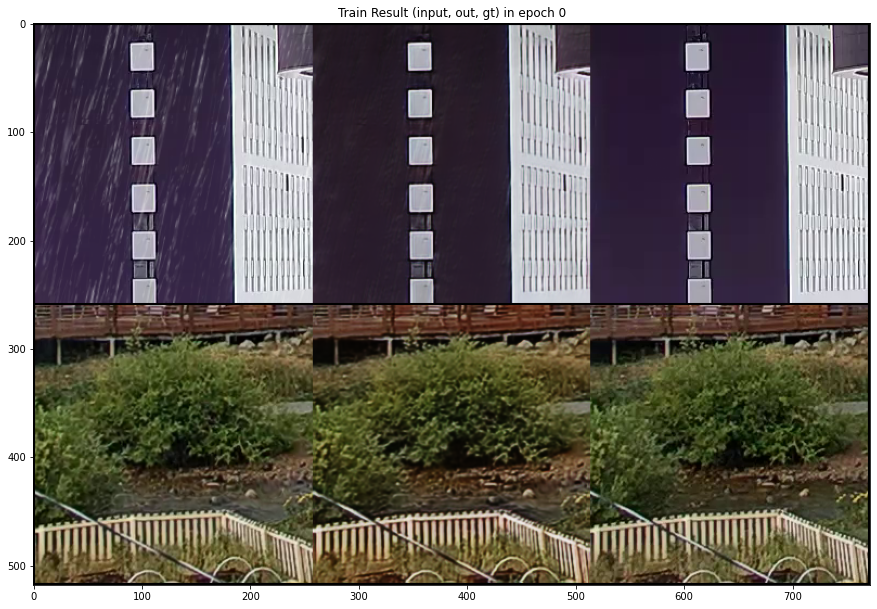

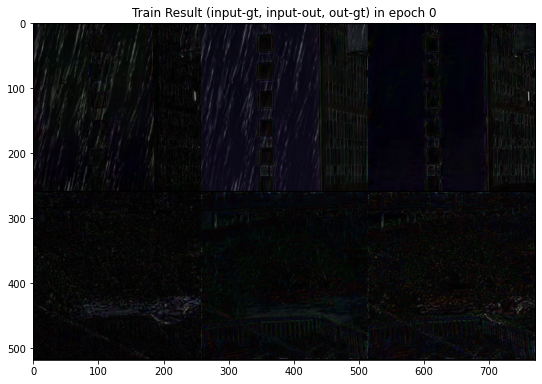

  0%|          | 0/224 [00:00<?, ?it/s]

Val Epoch	Time: 627.2173	Val Loss: 0.2109


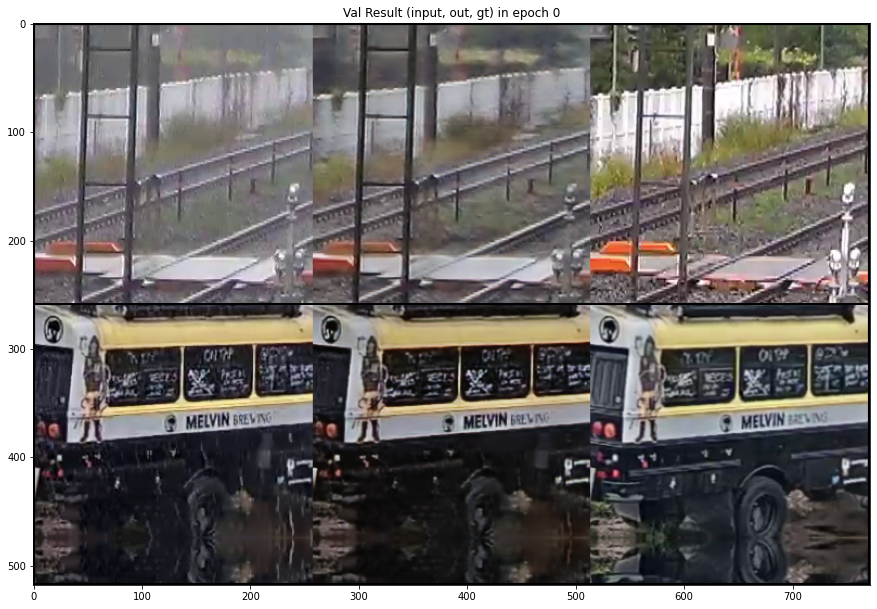

Saving...


  0%|          | 0/3260 [00:00<?, ?it/s]

In [ ]:
# TRAINING AND VALIDATION
best_epoch = 0
best_psnr = 0
for epoch in range(start_epoch, params['num_epochs']):
    epoch_start_time = time.time()
    epoch_loss = 0

    # TRAINING
    model.train()
    train_loop = tqdm(train_loader, leave=False, position=0)
    train_loop.set_description(f"Epoch {epoch}/{params['num_epochs']}")
    for batch_idx, batch_data in enumerate(train_loop):

        # Load the data
        input_img = batch_data['input_img'].cuda()
        target_img = batch_data['target_img'].cuda()

        # Check the current step
        current_step = epoch * len(train_loader) + batch_idx

        #########
        # Train #
        #########

        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass through the entire model (both parts)
        output_img, output_features = model(input_img, target_img)

        # Calculate losses between gt and output
        loss = 0

        if params['l1_loss_weight']:
            loss_l1 = criterion_l1(output_img, target_img)
            loss += params['l1_loss_weight'] * loss_l1
            loss_l1_log = loss_l1.item()

        if params['ssim_loss_weight']:
            loss_ssim = criterion_neg_ssim(output_img, target_img)
            loss += params['ssim_loss_weight'] * loss_ssim
            loss_ssim_log = loss_ssim.item()

        if params['robust_loss_weight']:
            loss_robust = criterion_robust(output_features)
            loss += params['robust_loss_weight'] * loss_robust
            loss_robust_log = loss_robust.item()

        # Backwards pass and step
        loss.backward()
        optimizer.step()

        # Log
        epoch_loss += loss.item()
        loss_log = loss.item()

        # Tensorboard
        if (current_step % params['tensorboard_log_step_train']) == 0:

            # Log loss
            writer.add_scalar('loss/train', loss_log, current_step)

            # Seperate loss
            if params['l1_loss_weight']:
                writer.add_scalar('l1_loss/train', loss_l1_log, current_step)
            if params['ssim_loss_weight']:
                writer.add_scalar('ssim_loss/train', loss_ssim_log, current_step)
            if params['robust_loss_weight']:
                writer.add_scalar('robust_loss/train', loss_robust_log, current_step)

            # Log images 
            log_img = torchvision.utils.make_grid(
                torch.cat([
                    input_img[0:2, ...].cpu() * 0.5 + 0.5,
                    output_img[0:2, ...].detach().cpu() * 0.5 + 0.5,
                    target_img[0:2, ...].cpu() * 0.5 + 0.5], dim=-1), nrow=1)

            log_img_difference = torchvision.utils.make_grid(
                  torch.cat([
                  torch.abs(input_img[0:2, ...].cpu() - target_img[0:2, ...].cpu()) / 2,
                  torch.abs(input_img[0:2, ...].cpu() - output_img[0:2, ...].detach().cpu()) / 2,
                  torch.abs(output_img[0:2, ...].detach().cpu() - target_img[0:2, ...].cpu()) / 2,
                  ], dim=-1), nrow=1)
            writer.add_image(
                'images/train (input, out, gt)', 
                log_img, current_step)
            writer.add_image(
                'images_diff/train (input-gt, input-out, out-gt)', 
                log_img_difference, current_step)

    # Print info
    print(
        f"Epoch: {epoch}\t"
        f"Time: {time.time() - epoch_start_time:.4f}\n"
        f"Train Loss: {epoch_loss / len(train_loader):.4f}\t"
        f"Learning Rate First {optimizer.param_groups[0]['lr']:.8f}\t")

    # Log images 
    log_img = torchvision.utils.make_grid(
        torch.cat([
            input_img[0:2, ...].cpu() * 0.5 + 0.5,
            output_img[0:2, ...].detach().cpu() * 0.5 + 0.5,
            target_img[0:2, ...].cpu() * 0.5 + 0.5], dim=-1), nrow=1)

    log_img = log_img.permute(1, 2, 0)

    log_img_difference = torchvision.utils.make_grid(
        torch.cat([
            torch.abs(input_img[0:2, ...].cpu() - target_img[0:2, ...].cpu()) / 2,
            torch.abs(input_img[0:2, ...].cpu() - output_img[0:2, ...].detach().cpu()) / 2,
            torch.abs(output_img[0:2, ...].detach().cpu() - target_img[0:2, ...].cpu()) / 2
            ], dim=-1), nrow=1)

    log_img_difference = log_img_difference.permute(1, 2, 0)

    # Show image
    show_img(
          img=log_img,
          title=f'Train Result (input, out, gt) in epoch {epoch}')
    show_img(
          img=log_img_difference,
          title=f'Train Result (input-gt, input-out, out-gt) in epoch {epoch}',
          figsize=(9, 9))

      ##############
      # Validation #
      ##############

    if epoch %  params['val_epoch'] == 0:
        model.eval()
        epoch_start_time = time.time()
        epoch_loss = 0

        val_loop = tqdm(val_loader, leave=False, position=0)
        val_loop.set_description('Val Epoch')
        for batch_idx, batch_data in enumerate(val_loop):

            # Load data
            input_img = batch_data['input_img'].cuda()
            target_img = batch_data['target_img'].cuda()

            # Check the current step
            current_step = epoch * len(val_loader) + batch_idx

            # Forward pass of model
            with torch.no_grad():

                output_img, output_feature = model(input_img, target_img)

                # Calculate losses between pseudo-gt and output
                loss = 0
                if params['l1_loss_weight']:
                    loss_l1 = criterion_l1(output_img, target_img)
                    loss += params['l1_loss_weight'] * loss_l1
                    loss_l1_log = loss_l1.item()

                if params['ssim_loss_weight']:
                    loss_ssim = criterion_neg_ssim(output_img, target_img)
                    loss += params['ssim_loss_weight'] * loss_ssim
                    loss_ssim_log = loss_ssim.item()

                epoch_loss += loss.item()
                loss_log = loss.item()

                # Tensorboard
                if (current_step % params['tensorboard_log_step_val']) == 0:

                    # Log loss
                    writer.add_scalar('loss/val', loss_log, current_step)

                    # Seperate loss
                    if params['l1_loss_weight']:
                        writer.add_scalar('l1_loss/val', loss_l1_log, current_step)
                    if params['ssim_loss_weight']:
                        writer.add_scalar('ssim_loss/val', loss_ssim_log, current_step)

                    # Log images 
                    log_img = torchvision.utils.make_grid(
                          torch.cat([
                              input_img[0:2, ...].cpu() * 0.5 + 0.5,
                              output_img[0:2, ...].cpu() * 0.5 + 0.5,
                              target_img[0:2, ...].cpu() * 0.5 + 0.5], dim=-1), nrow=1)
                    writer.add_image('images/val (input-out-gt)', log_img, current_step)

        # Print info
        avg_val_loss = epoch_loss / len(val_loader)
        print(
            f"Val Epoch\t"
            f"Time: {time.time() - epoch_start_time:.4f}\t"
            f"Val Loss: {avg_val_loss:.4f}")

        # Log images 
        log_img = torchvision.utils.make_grid(
            torch.cat([
                input_img[0:2, ...].cpu() * 0.5 + 0.5,
                output_img[0:2, ...].cpu() * 0.5 + 0.5,
                target_img[0:2, ...].cpu() * 0.5 + 0.5], dim=-1), nrow=1)
        log_img = log_img.permute(1, 2, 0)

        # Show image
        show_img(
            img=log_img,
            title=f'Val Result (input, out, gt) in epoch {epoch}')
        

    # Move the scheduler forward
    scheduler.step()

    # Save every few epochs
    if epoch % params['save_every'] == 0:
        print('Saving...')
        torch.save({
            'epoch': epoch, 
            'state_dict': model.state_dict(),
            'optimizer' : optimizer.state_dict()}, 
            os.path.join(params['save_dir'], f'model_epoch_{epoch}.pth'))

    # Tensorboard
    writer.flush()
# Close tensorboard
writer.close()